# Circuits in GraphiQ

## Overview

Circuits are a sequence of operations on quantum and classical registers, that define the generation of a quantum state.
In GraphiQ, circuits are represented as directed, acyclic graphs (DAGs), where the nodes represent operations/gates (e.g., Hadamard, CNOT, etc.), and the edges represent the registers on which they act.
Circuit objects can be exported in the openQASM format for plotting and inter-operability with other quantum tools.

The photonic quantum circuits have 3 types of registers:
1. **Emitter quantum registers:** solid state qubits which generate photons.
2. **Photonic quantum registers:** photon registers which encode a target quantum state.
3. **Classical registers:** store classical information, e.g., measurement results and classical control flow.

## Operations
The GraphiQ library includes standard quantum circuit gate sets, including 
1. **Operation type:** this is the class of the Operation object, and tells us what type of gate the Operation applies (e.g. CNOT, Hadamard)
2. **Operation registers:** The operation registers define which qubits/classical bits are affect or are affected by the operation. This must specify both the type of the register (classical, photonic quantum, emitter quantum) and its index.

In [43]:
import graphiq.circuit.ops as ops

# single qubit examples
## Hadamard on emitter 0
h = ops.Hadamard(register=0, reg_type="e")

## Pauli X gate on photon 1
paulix = ops.SigmaX(register=1, reg_type="p")


# controlled two-qubit gate example
# CNOT controlled by emitter 0, targeting photon 1
cnot = ops.CNOT(control=0, control_type="e", target=1, target_type="p")


## classically controlled gate & reset examples
# Classical CNOT, where emitter 2 is measured, saved to classical register 0 and conditionally applied to photon 1
ccnot = ops.ClassicalCNOT(
    control=2, control_type="e", target=1, target_type="p", c_register=0
)

# Emitter 0 is measured, saved to classical reg 0, conditional gate on photon 0
ccnot_reset = ops.MeasurementCNOTandReset(
    control=0, control_type="e", target=0, target_type="p", c_register=0
)

It may be useful to define a single operation object which wraps and applies multiple gates sequentially.

In [44]:
# NOTE: this applies first a phase gate, then a Hadamard gate on the register followed by a phase gate
HP_gate = ops.OneQubitGateWrapper([ops.Hadamard, ops.Phase], register=0, reg_type="p")

A noise model can be appended to each operation for simulating different environmental noise processes.

In [45]:
import graphiq.noise.noise_models as nm

h_with_noise = ops.CNOT(
    control=0, control_type="e", target=0, target_type="p", noise=nm.PauliError("X")
)

## Creating circuits

Circuits in GraphiQ are represented as directed, acyclic graphs (DAGs), where the nodes represent operations/gates (e.g., Hadamard, CNOT, etc.), and the edges represent the registers on which they act. In GraphiQ, circuits are represented using a `CircuitDAG` object.

![DAG example](../img/circuit_dag_explanation.PNG "DAG Circuit Example")

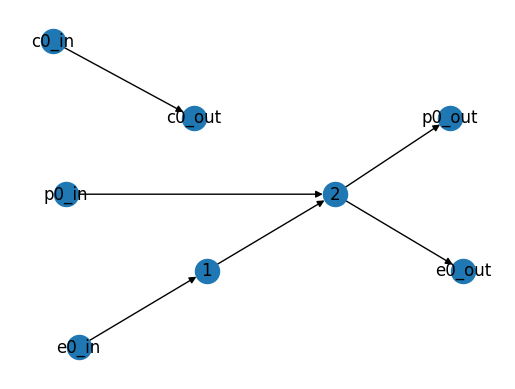

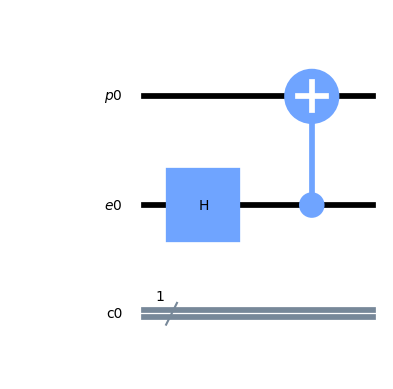

In [46]:
import graphiq.circuit.ops as ops
from graphiq.circuit.circuit_dag import CircuitDAG

# Create a circuit with 2 quantum registers and 1 classical registers
circuit = CircuitDAG(n_emitter=1, n_photon=1, n_classical=1)

circuit.add(ops.Hadamard(register=0, reg_type="e"))
circuit.add(ops.CNOT(control=0, control_type="e", target=0, target_type="p"))

circuit.draw_dag()  # DAG visualization--this shows the internal circuit representation
circuit.draw_circuit();  # this shows the circuit diagram

#### Adding to the circuit dynamically
Circuit size is not fixed, and can be updated dynamically. This is useful in developing circuit-design algorithms.

In [47]:
def print_circuit_size(c):
    print(f"Emitter num: {c.n_emitters}")
    print(f"Photon num: {c.n_photons}")
    print(f"Classical bit num: {c.n_classical}")
    c.draw_circuit()


circuit = CircuitDAG()
print(f"Circuit has {circuit.n_emitters}")

circuit.add(ops.CNOT(control=0, control_type="e", target=0, target_type="p"))
print(f"Circuit has {circuit.n_emitters}")

circuit.add_emitter_register()
print(f"Circuit has {circuit.n_emitters}")

Circuit has 0
Circuit has 1
Circuit has 2


#### Advanced circuit building (CircuitDAG specific)

In certain solver applications, it is useful to be able to swap, insert, and remove operations from the circuit. 

Initial circuit


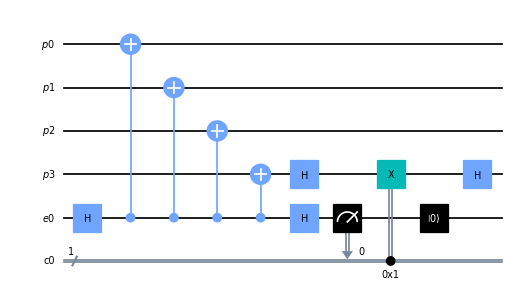

In [48]:
""" Consider """

import graphiq.benchmarks.circuits as circ

# This initial circuit is provided by the code base
circuit, _ = circ.ghz4_state_circuit()

print("Initial circuit")
circuit.draw_circuit();

Basic add: adds to the end of the circuit


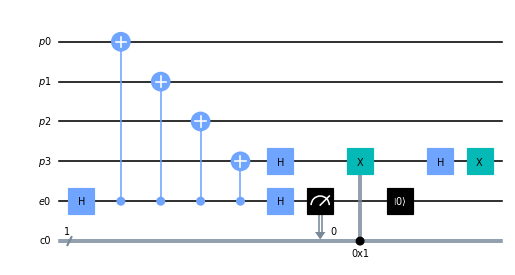

In [49]:
print("Basic add: adds to the end of the circuit")
circuit.add(ops.SigmaX(register=3, reg_type="p"))
circuit.draw_circuit();

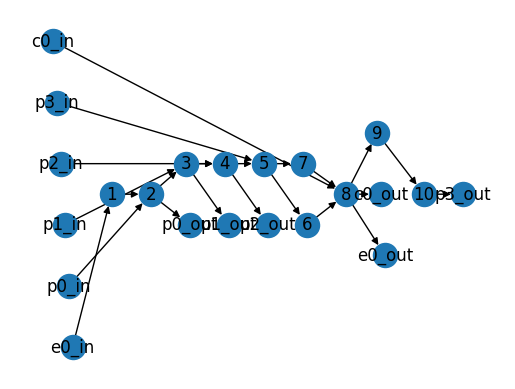

Insert at: insert operations on specific DAG edges (e.g. 3 and 4)


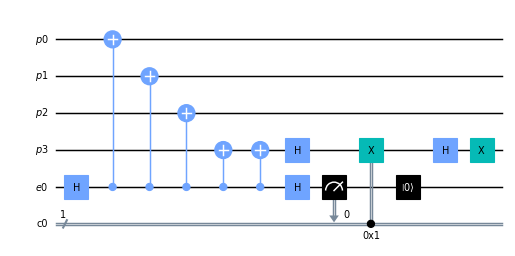

In [50]:
circuit.draw_dag()

"""
Say we want to add a second CNOT across e0, p3 (after the first one)
The DAG edge we add on is between nodes 5 and 7 (on "e0"), 5 and 6 (on "p3")

Note that this is not obvious, but the solvers typically track this information
"""

print("Insert at: insert operations on specific DAG edges (e.g. 3 and 4)")
circuit.insert_at(
    ops.CNOT(control=0, control_type="e", target=3, target_type="p"),
    [(5, 6, "p3"), (5, 7, "e0")],
)
circuit.draw_circuit();

Remove op: Remove a given operation


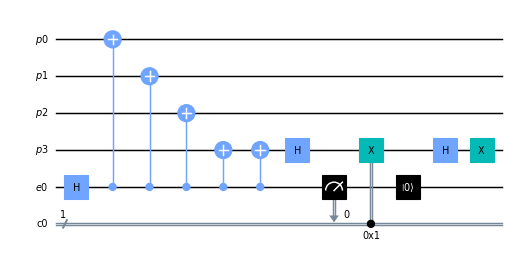

In [51]:
"""
Remove the hadamard on e0
"""

print("Remove op: Remove a given operation")
circuit.remove_op(7)
circuit.draw_circuit();

Our solvers can also swap components, but there is not explicit circuit class function for this.

#### Get a sequence of operations

In our software, the circuit is responsible for providing the compiler with a sequence of operations to compile. This sequence is built from the nodes of the graph provided in "topological" order:

In [52]:
op_seq = circuit.sequence()
print("operation objects (sequence):")
for op in op_seq:
    print(op)

operation objects (sequence):


### Saving and visualization

OpenQASM is a standard intermediate representation for defining a quantum circuit. Circuit objects in GraphiQ can be saved to and loaded from openQASM text files. 

**Note:** openQASM does not distinguish between photonic qubits and emitter qubits (this distinction is particular to photonic quantum computing applications). In our openQASM scripts, we distinguish photonic and emitter qubits by the naming convention of our registers.

In [53]:
""" Get openQASM string from circuit """

print("openQASM representation of the circuit:")
print(circuit.to_openqasm())

openQASM representation of the circuit:
OPENQASM 2.0;

gate h a { U(pi/2, 0, pi) a; }

gate x a { U(pi, 0, pi) a; }
qreg p0[1];
qreg p1[1];
qreg p2[1];
qreg p3[1];
qreg e0[1];
creg c0[1];

h e0[0];
CX e0[0], p0[0];
CX e0[0], p1[0];
CX e0[0], p2[0];
CX e0[0], p3[0];
CX e0[0], p3[0];
h p3[0];
barrier p0, p1, p2, p3, e0;
measure e0[0] -> c0[0]; 
if (c0==1) x p3[0]; 
barrier e0, p3; 
reset e0[0];
barrier p0, p1, p2, p3, e0;
h p3[0];
x p3[0];


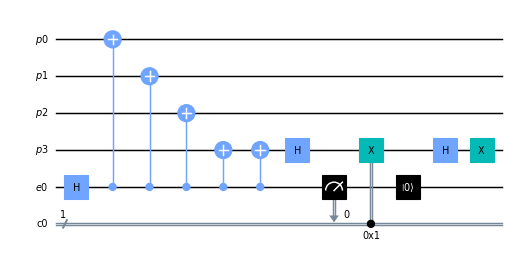

In [54]:
""" Define a new circuit with an openQASM string """

openqasm_str = circuit.to_openqasm()

circuit_copy = CircuitDAG.from_openqasm(openqasm_str)
circuit_copy.draw_circuit();

### Circuit resources

Some prebuilt circuits are available in the `benchmarks` folder.

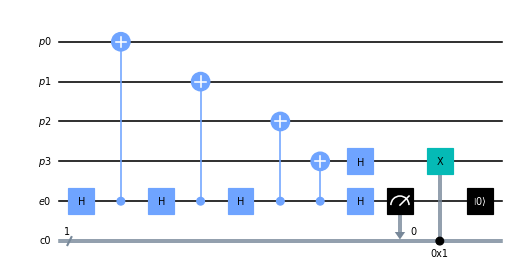

In [55]:
from graphiq.benchmarks.circuits import linear_cluster_4qubit_circuit

linear4_circ, _ = linear_cluster_4qubit_circuit()
linear4_circ.draw_circuit();